# Correct the ARCS labels

The labels from the KITTI data I downloaded were in the format:<br>
dz, dy, dx, x, y, z, yaw<br>
The ARCS labels seemed to be in the order:<br>
dz, dy, dx, x, z, y, yaw<br>
And the x, z, y coordinates were rotated 90 degrees counterclockwise. I'm going to make a second set of labels that is in the same format as KITTI.

Interesting. So right off the bat, my function is plotting the bounding boxes in a different spot that the point clouds (I'm working with lidar). I think this is because of how the previous person converted the data from the labeler. Will you be able to help me correct the labels?

So I have a bunch of .txt files and each one corresponds to a lidar frame. They look like this:
Car 0.00 0 -2.49 0.00 0.00 0.00 0.00 1.97 2.74 5.16 -29.63 -1.78 0.27 0.50
Car 0.00 0 -2.66 0.00 0.00 0.00 0.00 2.02 2.71 4.95 -30.38 -0.21 26.84 5.20
Car 0.00 0 -2.65 0.00 0.00 0.00 0.00 2.13 2.48 5.36 -28.66 -0.11 29.51 5.21
Motorcycle 0.00 0 2.22 0.00 0.00 0.00 0.00 1.30 1.19 2.58 6.27 0.43 24.76 3.77

So, I basically ignore the first 8 values (the type of car and the 7 numerical values) when I'm just drawing 3d bounding boxes.

## ACTUALLY- THE DIFFERENCE BETWEEN ARCS AND KITTI (not the raw data I was working with) IS A NEGATIVE YAW, so I'll just do that.

### Later note. Now I want a label set that has the same format as the pointpillars predictions (which I guess is not the same as kitti? Annoying. I know the function that put the predictions in the correct spot on the LiDAR frames, so I'll see how to convert to that and make a pillar_pred_format_labels folder

### Vizualize the labels to see what transformations I need to make them like the pointpillars predictions

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [66]:
# inference
frame = '006000'
bin_path = '../data/velodyne_points/' + frame + '.bin'
label_path = '../data/labels/' + frame + '.txt'
points = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 4)

In [67]:
example_pred_frame_006000 = {'predictions': 
   [{'labels_3d': [1, 2, 2, 2, 2, 2], 
     'scores_3d': [0.37436285614967346, 0.8860181570053101, 0.846523106098175, 0.5451850891113281, 0.4473717212677002, 0.4247516095638275], 
     'bboxes_3d': [[5.028863430023193, -15.78142261505127, -0.721443772315979, 1.7926948070526123, 0.6943190097808838, 1.7274187803268433, 1.5951296091079712], 
                   [2.158820867538452, 25.521644592285156, -2.0219573974609375, 4.410659313201904, 1.713751196861267, 1.4779202938079834, -1.0621992349624634], 
                   [10.126334190368652, 26.06059455871582, -1.8438267707824707, 4.386297225952148, 1.6843407154083252, 1.5065099000930786, 2.106016159057617], 
                   [29.500598907470703, -14.849691390991211, 0.2762340307235718, 4.206188201904297, 1.5862056016921997, 1.5070021152496338, 2.1125431060791016], 
                   [28.044879913330078, -20.803447723388672, 0.47694647312164307, 4.386697292327881, 1.6085255146026611, 1.3169963359832764, 1.2406989336013794], 
                   [31.531211853027344, -25.256420135498047, 0.4247567653656006, 4.498119831085205, 1.661558985710144, 1.4026427268981934, 4.414409637451172]], 
     'box_type_3d': 'LiDAR'}], 'visualization': []}
print(example_pred_frame_006000)

{'predictions': [{'labels_3d': [1, 2, 2, 2, 2, 2], 'scores_3d': [0.37436285614967346, 0.8860181570053101, 0.846523106098175, 0.5451850891113281, 0.4473717212677002, 0.4247516095638275], 'bboxes_3d': [[5.028863430023193, -15.78142261505127, -0.721443772315979, 1.7926948070526123, 0.6943190097808838, 1.7274187803268433, 1.5951296091079712], [2.158820867538452, 25.521644592285156, -2.0219573974609375, 4.410659313201904, 1.713751196861267, 1.4779202938079834, -1.0621992349624634], [10.126334190368652, 26.06059455871582, -1.8438267707824707, 4.386297225952148, 1.6843407154083252, 1.5065099000930786, 2.106016159057617], [29.500598907470703, -14.849691390991211, 0.2762340307235718, 4.206188201904297, 1.5862056016921997, 1.5070021152496338, 2.1125431060791016], [28.044879913330078, -20.803447723388672, 0.47694647312164307, 4.386697292327881, 1.6085255146026611, 1.3169963359832764, 1.2406989336013794], [31.531211853027344, -25.256420135498047, 0.4247567653656006, 4.498119831085205, 1.6615589857

In [68]:
def set_axes_limited(ax, limit=50):
    # Set axes to a fixed range around the origin to limit view to +/- 'limit' meters.
    ax.set_xlim3d([-limit, limit])
    ax.set_ylim3d([-limit, limit])
    ax.set_zlim3d([-limit, limit])

In [69]:
def set_axes_equal(ax):
    """Make axes of 3D plot have equal scale so that spheres appear as spheres, cubes as cubes, etc."""
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    box_size = max([x_range, y_range, z_range]) / 2.0

    ax.set_xlim3d([x_middle - box_size, x_middle + box_size])
    ax.set_ylim3d([y_middle - box_size, y_middle + box_size])
    ax.set_zlim3d([z_middle - box_size, z_middle + box_size])

In [70]:
# Function to plot the bounding box
def plot_bbox(ax, bbox, color):
    # Bounding box order that displays pointpillars predictions correctly   
    x, y, z, dx, dy, dz, yaw = bbox

    
    corners = np.array([
        [x - dx/2, y - dy/2, z - dz/2],
        [x + dx/2, y - dy/2, z - dz/2],
        [x + dx/2, y + dy/2, z - dz/2],
        [x - dx/2, y + dy/2, z - dz/2],
        [x - dx/2, y - dy/2, z + dz/2],
        [x + dx/2, y - dy/2, z + dz/2],
        [x + dx/2, y + dy/2, z + dz/2],
        [x - dx/2, y + dy/2, z + dz/2]
    ])
    

    # Rotate corners around the Z-axis (around their centers)
    rotation_matrix = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw),  np.cos(yaw), 0],
        [0,            0,           1]
    ])

    # # Adjust the corners to be about the origin for rotation, then add the [x, y, z] back after rotation
    corners = corners - np.array([x, y, z])
    corners = np.dot(corners, rotation_matrix.T)
    corners += np.array([x, y, z])
    
    # Define the edges of the bounding box
    edges = [
        (0, 1), (1, 2), (2, 3), (3, 0),
        (4, 5), (5, 6), (6, 7), (7, 4),
        (0, 4), (1, 5), (2, 6), (3, 7)
    ]
    # Plot the edges
    for edge in edges:
        ax.plot3D(*zip(corners[edge[0]], corners[edge[1]]), color=color, linewidth=1)

In [71]:
# This function is to figure out which tranformations I need to apply to get the
# bounding boxes to display with the same value order as the pointpillars predictions
def reformat_to_pointpillars(bbox):
    print(bbox)
    new_bbox = [bbox[5], -bbox[3], bbox[4], bbox[0], bbox[2], bbox[1], bbox[6]]

    print(new_bbox)
    print()

    return new_bbox

In [72]:
def read_kitti_labels(label_path):
    bboxes = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if parts[0] != 'DontCare':
                bbox = [float(value) for value in parts[8:15]]  # Extract the bounding box dimensions and location
                bboxes.append(bbox)

    new_bboxes = []
    for bbox in bboxes:
        new_bboxes.append(reformat_to_pointpillars(bbox))
    
    return np.array(new_bboxes)

[2.46, 2.55, 5.19, -25.69, -1.4, 2.26, 0.53]
[2.26, 25.69, -1.4, 2.46, 5.19, 2.55, 0.53]

[2.15, 2.57, 5.67, -32.9, -1.55, 2.12, 3.67]
[2.12, 32.9, -1.55, 2.15, 5.67, 2.57, 3.67]

[2.12, 2.56, 4.7, -26.15, -1.04, 10.2, 3.63]
[10.2, 26.15, -1.04, 2.12, 4.7, 2.56, 3.63]

[2.32, 2.64, 5.03, 14.69, 1.3, 29.43, 3.67]
[29.43, -14.69, 1.3, 2.32, 5.03, 2.64, 3.67]



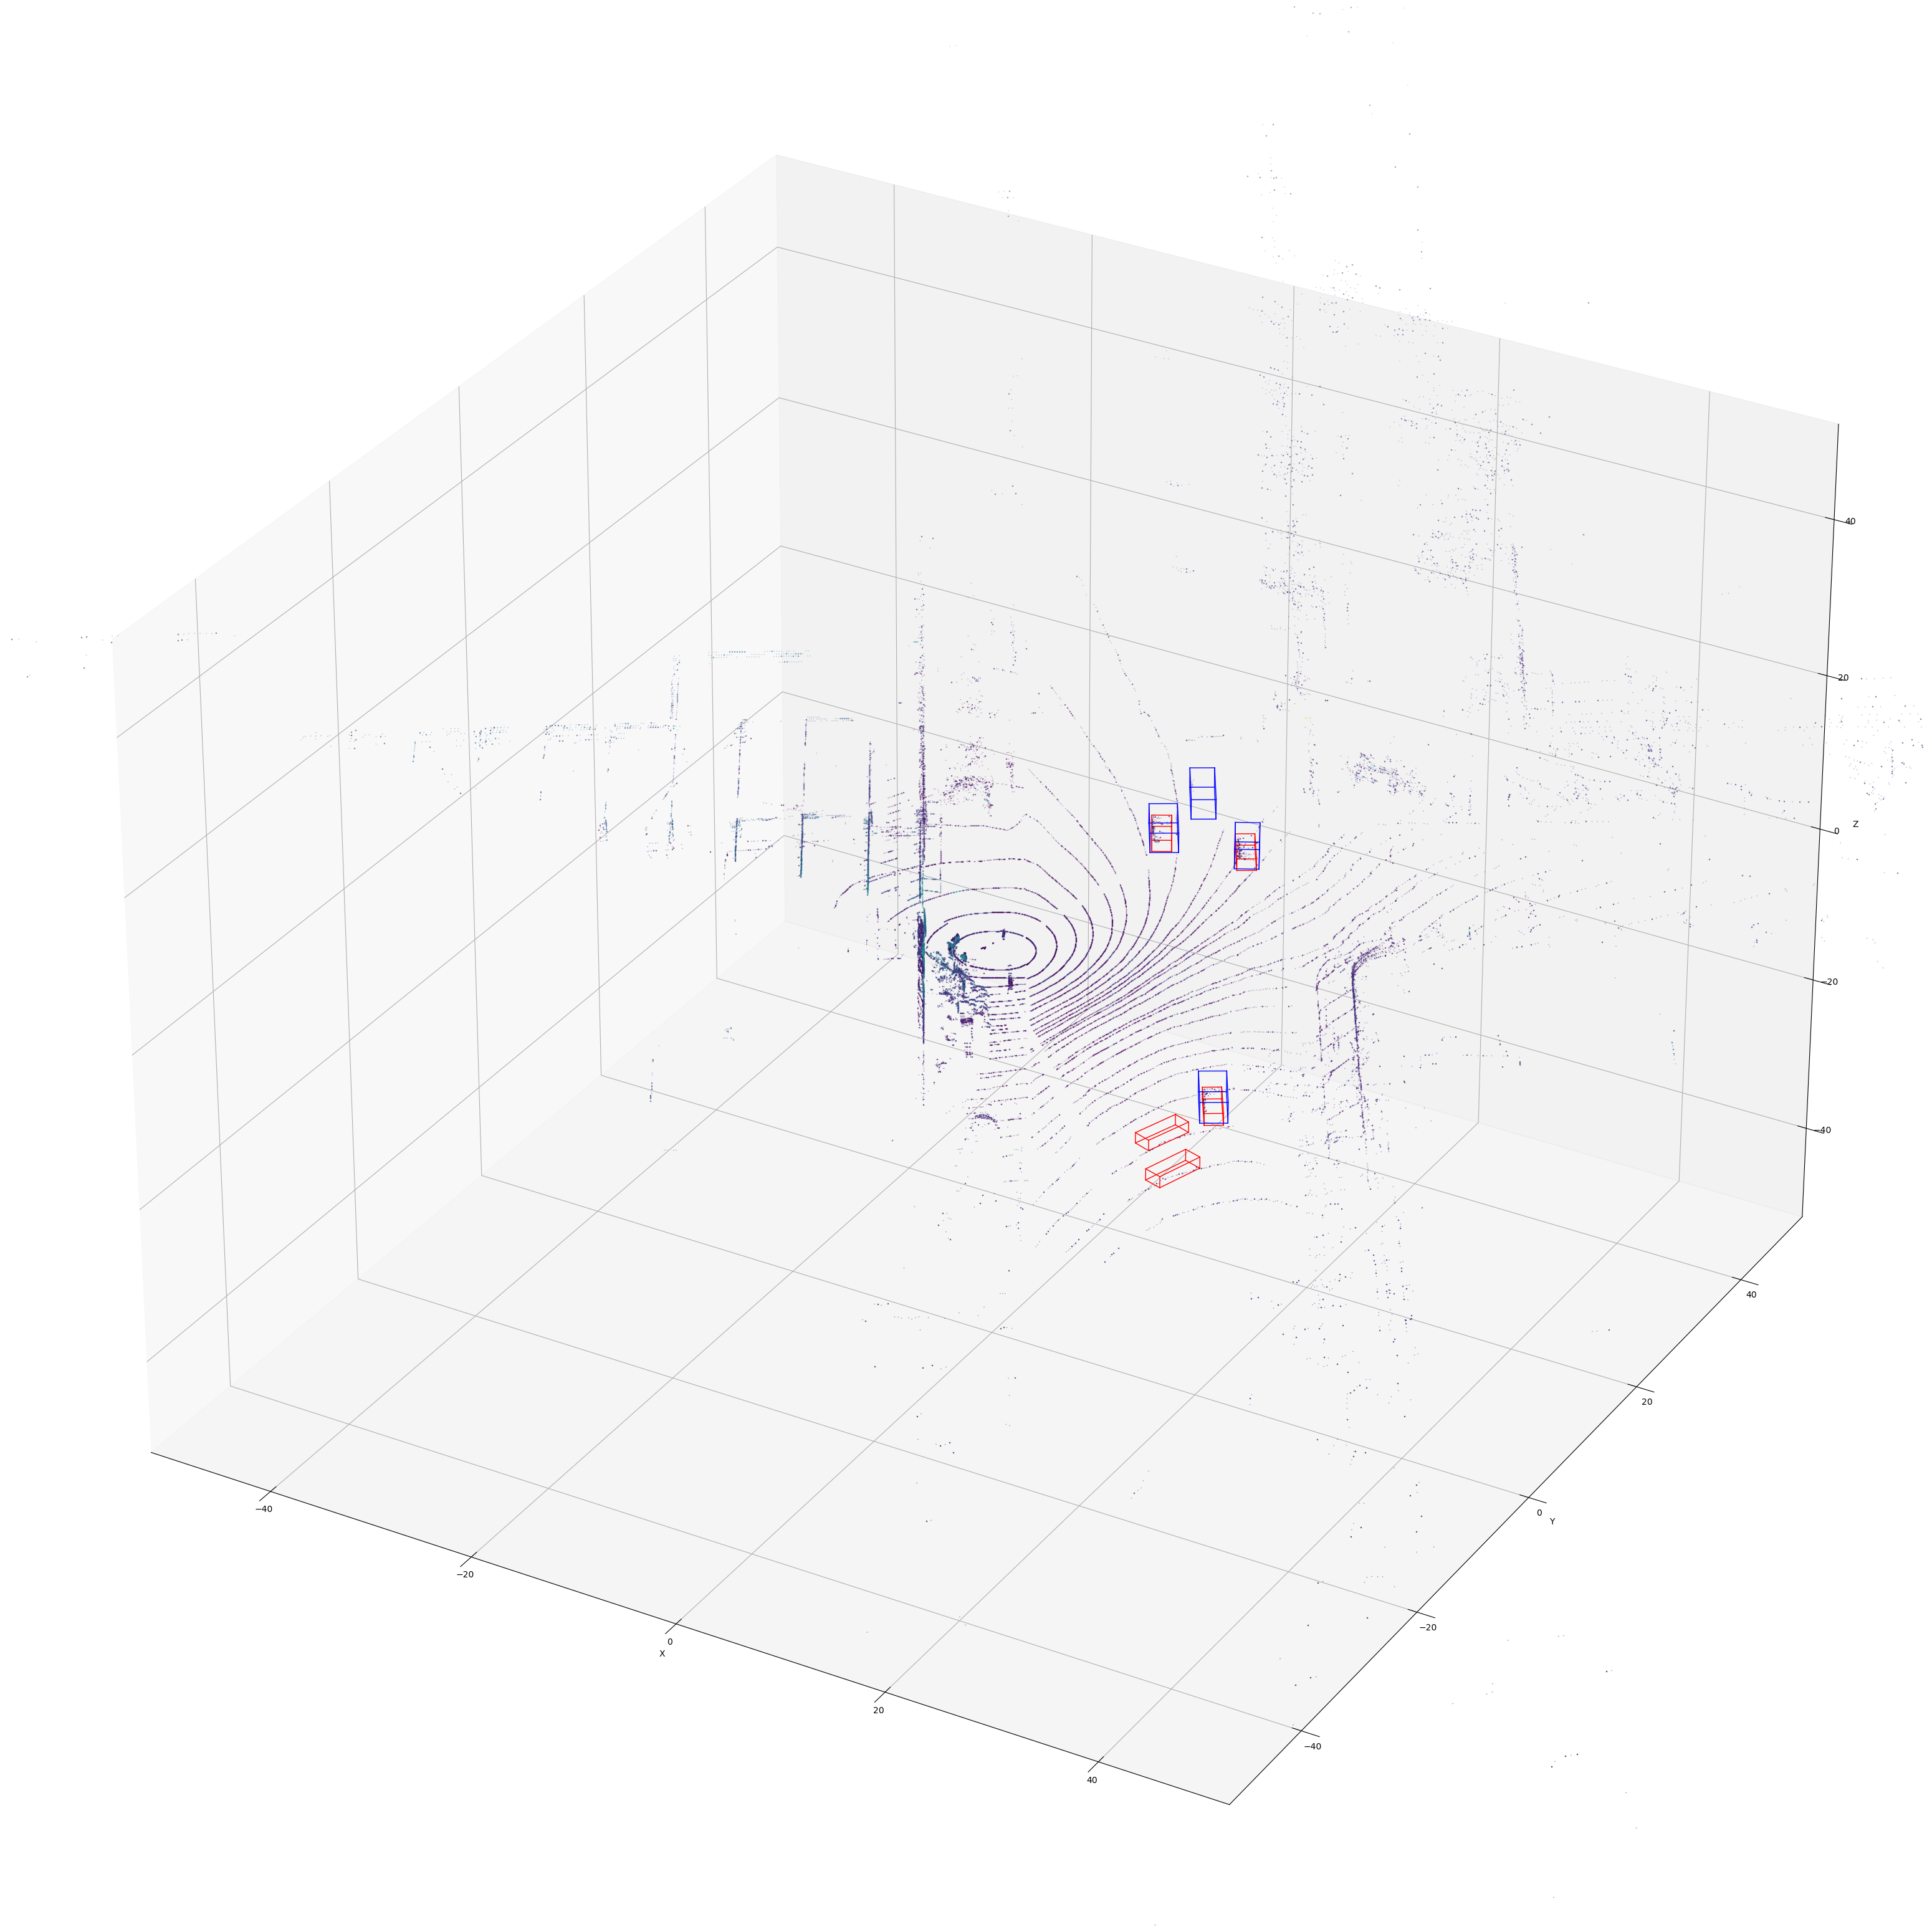

In [73]:
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=0.1, c=points[:, 3], cmap='viridis', marker=',')

score_threshold = 0.0

# Plot each bounding box with score above threshold
for pred in example_pred_frame_006000['predictions']:
    for label, score, bbox in zip(pred['labels_3d'], pred['scores_3d'], pred['bboxes_3d']):
        if score > score_threshold and label == 2:
            plot_bbox(ax, bbox, 'r')
            
# Plot ground truth
for bbox in read_kitti_labels(label_path):
    plot_bbox(ax, bbox, 'b')
            
# Setting axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')




set_axes_equal(ax)

# Setting axes properties with a limited range
set_axes_limited(ax)

# Show the plot
plt.show()

# Save the figure
fig.savefig('3d_scatter_with_bboxes.png', dpi=300)

## Correct the labels

In [75]:
# If false, this just inverts the yaw to be consistent with kitti labels from tracklets
convert_to_point_pillars = True

In [76]:
import os
import numpy as np
from pathlib import Path
import itertools

In [77]:
DATA_DIR_ROOT = '../data'

In [78]:
def get_labels(label_path):
    labels = []
    with open(label_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            bbox = []
            # Add the category as a string
            bbox.append(parts[0])
            # Extract the bounding box dimensions and location as 
            bbox = bbox + [float(value) for value in parts[1:15]]  
            bbox[2] = int(bbox[2])
            labels.append(bbox)
    return np.array(labels)

In [79]:
def save_labels(label_path, labels):
    with open(label_path, 'w') as file:
        for label in labels:
            # Join each element of the label list with a space and write to the file
            file.write(' '.join(map(str, label)) + '\n')

In [86]:
def get_pillar_pred_format(label):
    print(label)
    # new_bbox = [bbox[5], -bbox[3], bbox[4], bbox[0], bbox[2], bbox[1], bbox[6]]
    new_label = [label[0], label[1], label[2], label[3], label[4],
                 label[5], label[6], label[7], label[13], str(-float(label[11])),
                 label[12], label[8], label[10], label[9], label[14]]
    print(new_label)
    print()

    return new_label

In [88]:
# Go into the ARCS data folder
labels_dir_path = Path(DATA_DIR_ROOT, 'labels')
# Create correct ARCS data folder
if convert_to_point_pillars:
    corrected_dir_labels_path = Path(DATA_DIR_ROOT, 'pillar_pred_format_labels')
else:
    corrected_dir_labels_path = Path(DATA_DIR_ROOT, 'corrected_labels')
corrected_dir_labels_path.mkdir(exist_ok=True)
# For each .txt file
for label_file in itertools.islice(labels_dir_path.iterdir(), 10):
# for label_file in labels_dir_path.iterdir():
    if str(label_file).endswith('.txt'):
        print(label_file)
        # Get the names of the file
        # Get the base filename ('006428.txt')
        filename = os.path.basename(label_file)
        # Split the filename from the extension ('006428', '.txt')
        file_id, extension = os.path.splitext(filename)
        new_file_location = Path(corrected_dir_labels_path, filename)
        
        # Make a list of corrected labels
        corrected_labels_list = []
        # For each label in the file
        labels = get_labels(label_file)

        if convert_to_point_pillars:
            new_labels = []
            for label in labels:
                new_labels.append(get_pillar_pred_format(label))
            labels = new_labels
            print()
        else:
            for label in labels:
                label[-1] = str(-float(label[-1]))
        # Save the new labels to a new file in the corrected ARCS data folder
        save_labels(new_file_location, labels)
    

..\data\labels\006436.txt
['Car' '0.0' '0' '2.43' '0.0' '0.0' '0.0' '0.0' '1.94' '2.73' '4.49'
 '-27.1' '-2.09' '-6.66' '0.55']
['Car', '0.0', '0', '2.43', '0.0', '0.0', '0.0', '0.0', '-6.66', '27.1', '-2.09', '1.94', '4.49', '2.73', '0.55']


[['Car', '0.0', '0', '2.43', '0.0', '0.0', '0.0', '0.0', '-6.66', '27.1', '-2.09', '1.94', '4.49', '2.73', '0.55']]
..\data\labels\006437.txt
['Car' '0.0' '0' '2.44' '0.0' '0.0' '0.0' '0.0' '1.96' '2.7' '4.56'
 '-26.18' '-2.02' '-6.1' '0.55']
['Car', '0.0', '0', '2.44', '0.0', '0.0', '0.0', '0.0', '-6.1', '26.18', '-2.02', '1.96', '4.56', '2.7', '0.55']


[['Car', '0.0', '0', '2.44', '0.0', '0.0', '0.0', '0.0', '-6.1', '26.18', '-2.02', '1.96', '4.56', '2.7', '0.55']]
..\data\labels\006438.txt
['Car' '0.0' '0' '2.46' '0.0' '0.0' '0.0' '0.0' '1.99' '2.68' '4.63'
 '-25.27' '-1.95' '-5.54' '0.55']
['Car', '0.0', '0', '2.46', '0.0', '0.0', '0.0', '0.0', '-5.54', '25.27', '-1.95', '1.99', '4.63', '2.68', '0.55']


[['Car', '0.0', '0', '2.46', '0.0', '